**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix

import shap

**Loading the Dataset**

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

**Add Sensitive Attribute**

In [3]:
np.random.seed(42)
X["group"] = np.random.choice([0, 1], size=len(X))  # demographic group

**Splitting Data - Trainig/Testing**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=["group"]),
    y,
    test_size=0.3,
    random_state=42

)

group_test = X.loc[X_test.index, "group"]

**Train Model**

In [6]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


**Evaluate Performance**

In [7]:
probs = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)
print("ROC-AUC:", round(auc, 3))

ROC-AUC: 0.998


**Bias Analysis**

In [8]:
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

threshold = 0.5
preds = (probs > threshold).astype(int)

results = {}
for g in [0, 1]:
    idx = group_test == g
    results[g] = false_negative_rate(
        y_test[idx], preds[idx]
    )


print("False Negative Rate by Group:", results)


    

False Negative Rate by Group: {0: np.float64(0.0196078431372549), 1: np.float64(0.017543859649122806)}


**SHAP Explainability**

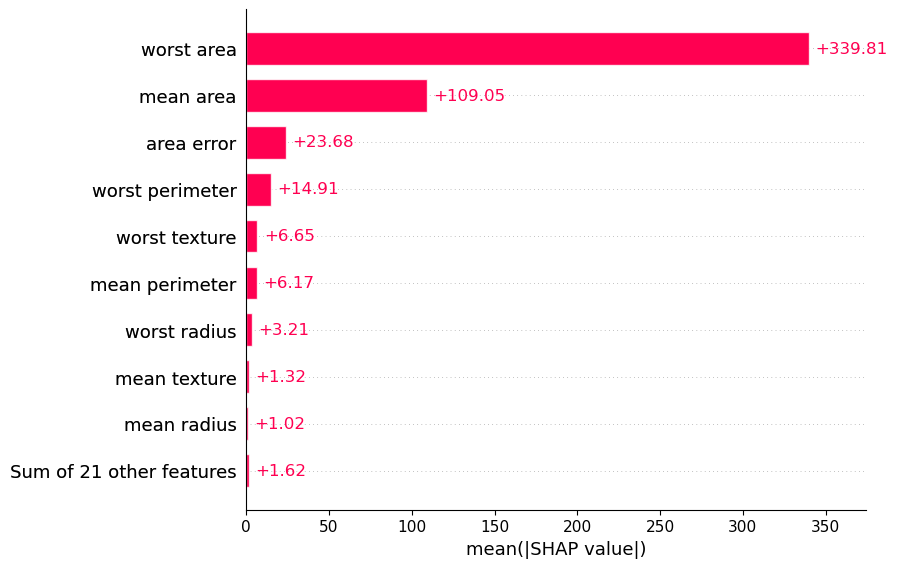

In [9]:
explainer = shap.Explainer(model["clf"], X_train)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)